## 第十二週：主題模型（中文）
**Autor**: 黃天原 <br>

本週課程為 **主題模型** ，學習如何將文本進行主題模型分析。<br>
文件主題模型採用非監督式學習的方式，不事先人為做標籤與註解，訓練的資料是從資料文本得來，讓我們可以規模化給予大量文本，而訓練出主題模型，其中最為知名為LDA模型，也是本次課程主要的教學目標，本 jupyter notebook 是以中文文本為示範。<br>
<br>
這次課程分為四個部分：
1. 介紹使用到的套件 
2. 將資料進行前處理 
3. lexicon-based 的主題模型
4. LDA 主題模型 
5. 視覺化主題模型 
6. 主題模型的應用

## 1. 套件說明
本次實作過程中使用到的相關套件，在課堂中我們將會簡單的展示這些套件的使用方式，關於各個套件的進階使用請同學參照其官網的說明。
+ gensim: 主題模型函式庫
+ pyLDAvis: 互動式LDA視覺化套件

In [2]:
import time 
from collections import Counter
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import jieba
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.matutils import corpus2csc 

import pyLDAvis
import pyLDAvis.gensim_models

In [3]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [4]:
from matplotlib import font_manager
font_set = {f.name for f in font_manager.fontManager.ttflist}
# matplotlib.rcParams['font.family'] = ['Noto Sans Mono CJK TC', 'sans-serif']
plt.rcParams["font.sans-serif"] = ["Noto Sans CJK JP"]
# plt.plot((1, 2, 3), (4, 3, -1))
# plt.title("聲量圖")

## 2. 資料前處理

In [5]:
udn = pd.read_csv("raw_data/udn_news_03.csv")  # 匯資料
udn.head(3)

,system_id,artTitle,artDate,artCatagory,artSecondCatagory,artUrl,artContent,dataSource
0,1,經典賽／夠經典！大聯盟拍賣網站 潘威倫球衣出價最高,2023-03-01 11:46:00,運動,經典賽,https://udn.com/news/story/10785/7001130,世界棒球經典賽將在3月8日開打，大聯盟也在拍賣網站推出歷屆經典賽實戰用品供球迷競標，目前所有...,UDN
1,2,經典賽／神秘巴拿馬30人名單揭曉 5大聯盟+1前中職洋投,2023-03-01 12:09:00,運動,經典賽,https://udn.com/news/story/10785/7001237,世界棒球經典賽將在3月8日開打，中華隊首戰對手巴拿馬隊今天公布最終30人名單，其中有5名現役...,UDN
2,3,經典賽／大谷翔平發文宣告與日本隊合體 何時出賽還不確定,2023-03-01 17:21:00,運動,經典賽,https://udn.com/news/story/10785/7002171,世界棒球經典賽將在下周3月8日開打，將代表日本出征的大谷翔平今天進行春訓初登板，賽後馬上啟程...,UDN


In [6]:
# 移除網址格式
# 只留下中文字
udn["artContent"] = udn["artContent"].str.replace("(http|https)://.*", "", regex=True)
udn["artTitle"] = udn["artTitle"].str.replace("(http|https)://.*", "", regex=True)
udn["artContent"] = udn["artContent"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
udn["artTitle"] = udn["artTitle"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
udn['content'] = udn['artContent']


udn = udn.loc[:,["content", "artUrl", "artCatagory", 'artDate']]  # 文章內容 文章連結
udn.head(3)

,content,artUrl,artCatagory,artDate
0,世界棒球經典賽將在月日開打大聯盟也在拍賣網站推出歷屆經典賽實戰用品供球迷競標目前所有拍賣物品...,https://udn.com/news/story/10785/7001130,運動,2023-03-01 11:46:00
1,世界棒球經典賽將在月日開打中華隊首戰對手巴拿馬隊今天公布最終人名單其中有名現役大聯盟球員還有...,https://udn.com/news/story/10785/7001237,運動,2023-03-01 12:09:00
2,世界棒球經典賽將在下周月日開打將代表日本出征的大谷翔平今天進行春訓初登板賽後馬上啟程返日準備...,https://udn.com/news/story/10785/7002171,運動,2023-03-01 17:21:00


In [7]:
# 設定繁體中文詞庫
jieba.set_dictionary("./dict/dict.txt")

# 新增stopwords
# jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tags才會作用
with open("./dict/stopwords.txt", encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

# 設定斷詞 function
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

udn["words"] = udn["content"].apply(getToken)
udn.head()

Building prefix dict from /home/evan19983314/SMA/SMA_2023S/week12_topic_model/dict/dict.txt ...
2023-04-30 22:11:16,235 : DEBUG : Building prefix dict from /home/evan19983314/SMA/SMA_2023S/week12_topic_model/dict/dict.txt ...
Loading model from cache /tmp/jieba.u29602a0b4db066f0058e27c689821199.cache
2023-04-30 22:11:16,239 : DEBUG : Loading model from cache /tmp/jieba.u29602a0b4db066f0058e27c689821199.cache
Loading model cost 0.789 seconds.
2023-04-30 22:11:17,027 : DEBUG : Loading model cost 0.789 seconds.
Prefix dict has been built successfully.
2023-04-30 22:11:17,029 : DEBUG : Prefix dict has been built successfully.


,content,artUrl,artCatagory,artDate,words
0,世界棒球經典賽將在月日開打大聯盟也在拍賣網站推出歷屆經典賽實戰用品供球迷競標目前所有拍賣物品...,https://udn.com/news/story/10785/7001130,運動,2023-03-01 11:46:00,"[世界, 棒球, 經典賽, 將在, 開打, 大聯盟, 拍賣, 網站, 推出, 歷屆, 經典賽..."
1,世界棒球經典賽將在月日開打中華隊首戰對手巴拿馬隊今天公布最終人名單其中有名現役大聯盟球員還有...,https://udn.com/news/story/10785/7001237,運動,2023-03-01 12:09:00,"[世界, 棒球, 經典賽, 將在, 開打, 中華隊, 首戰, 對手, 巴拿馬, 今天, 公布..."
2,世界棒球經典賽將在下周月日開打將代表日本出征的大谷翔平今天進行春訓初登板賽後馬上啟程返日準備...,https://udn.com/news/story/10785/7002171,運動,2023-03-01 17:21:00,"[世界, 棒球, 經典賽, 將在, 下周, 開打, 代表, 日本, 出征, 大谷翔平, 今天..."
3,旅美投手鄧愷威加入中華隊的時間出爐總教練林岳平今天表示為了配合大聯盟的規範鄧愷威今天搭機返台...,https://udn.com/news/story/10785/7002266,運動,2023-03-01 17:40:00,"[旅美, 投手, 鄧愷威, 加入, 中華隊, 時間, 出爐, 總教練, 林岳平, 今天, 表..."
4,古巴隊昨天以擊敗味全龍拿下來台後熱身賽首勝這三場比賽中華隊教練團都有觀察總教練大餅林岳平更指...,https://udn.com/news/story/10785/7002313,運動,2023-03-01 17:56:00,"[古巴隊, 昨天, 擊敗, 味全龍, 拿下來台, 熱身賽, 首勝, 這三場, 比賽, 中華隊..."


## 3. Lexicon-based / 人工給定主題的主題模型

In [8]:
udn['artCatagory'].unique()

array(['運動', '股市', '兩岸'], dtype=object)

In [9]:
## 定義主題
sport_cnt = udn.loc[udn['artCatagory'] == '運動',:]['words'].explode().value_counts().head(100)
sport_cnt.index

Index(['經典賽', '今天', '中華隊', '世界', '棒球', '比賽', '日本', '台灣', '賽事', '球員', '預賽',
       '投手', '戰績', '球隊', '賽程', '球迷', '表示', '選手', '表現', '大聯盟', '分組', '先發', '比分',
       '分析', '完整', '專欄', '安打', '新聞', '即時', '大谷翔平', '高中', '擊敗', '今年', '最後',
       '拿下', '面對', '張育成', '美國', '聯盟', '去年', '冠軍', '巴拿馬', '最終', '開打', '東京',
       '主場', '昨天', '運動', '成績', '成為', '熱身賽', '晉級', '強賽', '教練', '希望', '記者', '機會',
       '時間', '日本隊', '中華', '古巴', '本屆', '出賽', '領先', '進行', '球場', '棒球場', '對決',
       '職棒', '今晚', '敲出', '荷蘭隊', '古巴隊', '大谷', '總教練', '本季', '籃板', '好手', '聯賽',
       '荷蘭', '義大利', '義大利隊', '登場', '球星', '巨蛋', '中信', '對手', '目前', '洲際', '參加',
       '勇士', '出現', '攝影', '排名', '打擊', '紀錄', '南韓', '確定', '獲得', '球團'],
      dtype='object')

In [10]:
stock_cnt = udn.loc[udn['artCatagory'] == '股市',:]['words'].explode().value_counts().head(200)
pprint(" ".join(stock_cnt.index))

('億元 市場 營收 去年 今年 公司 成長 表示 投資 持續 指數 純益 台股 美國 第季 股利 產品 獲利 每股 需求 營運 表現 現金 台灣 產業 '
 '年增 股價 預期 目前 投資人 影響 今日 全球 法人 銀行 客戶 上漲 主要 升息 合併 未來 指出 增加 董事會 殖利率 經濟 公布 相關 外資 '
 '股息 配發 股票 昨日 庫存 企業 配息 金融 年減 風險 帶動 盈餘 發展 展望 新高 提升 業務 預估 維持 台積電 國際 價格 上市 可望 基金 '
 '下跌 布局 近期 漲幅 資金 半導體 能源 同期 大陸 下半年 中國 電子 超過 機會 提供 集團 債券 動能 看好 資本 服務 受惠 買超 聯準會 '
 '投信 出現 預計 累計 通膨 訂單 證券 業績 包括 財報 政策 應用 科技 積極 毛利率 今天 淨利 股市 認為 疫情 期貨 調整 新台幣 交易 歷史 '
 '股東 穩定 方面 成為 出貨 金額 目標 長期 減少 進行 公告 景氣 相對 電動車 品牌 資產 美股 智慧 趨勢 利率 決議 建議 系統 虧損 銷售 '
 '透過 成本 技術 大幅 擴大 觀察 賣超 三大 金融股 個股 董事長 生產 計算 陸續 旗下 矽谷 伺服器 類股 規模 後續 時間 優於 消費 收盤價 '
 '達億 美元 上半年 鴻海 族群 震盪 合作 行情 關注 資訊 顯示 大盤 年度 營業 走勢 回升 情況 創新 股稅 投入 後市 永續 有望 水準 過去 '
 '掛牌 中心 衰退')


In [11]:
stock_cnt = udn.loc[udn['artCatagory'] == '兩岸',:]['words'].explode().value_counts().head(200)
stock_cnt.index.to_list()

['中國',
 '大陸',
 '表示',
 '發展',
 '經濟',
 '報導',
 '國家',
 '美國',
 '香港',
 '工作',
 '企業',
 '公司',
 '指出',
 '台灣',
 '今年',
 '兩岸',
 '市場',
 '政府',
 '習近平',
 '政策',
 '北京',
 '全國',
 '國際',
 '去年',
 '問題',
 '人民幣',
 '中共',
 '認為',
 '增長',
 '合作',
 '關係',
 '機構',
 '中央',
 '顯示',
 '投資',
 '全球',
 '產業',
 '大學',
 '上海',
 '包括',
 '目前',
 '報告',
 '金融',
 '發布',
 '國務院',
 '會議',
 '進行',
 '相關',
 '億元',
 '汽車',
 '網友',
 '安全',
 '疫情',
 '交流',
 '技術',
 '政治',
 '推動',
 '新聞',
 '主席',
 '銀行',
 '政協',
 '重要',
 '影響',
 '社會',
 '恢復',
 '人員',
 '情況',
 '集團',
 '持續',
 '人士',
 '建設',
 '科技',
 '主要',
 '提供',
 '活動',
 '中心',
 '數據',
 '服務',
 '方面',
 '希望',
 '成為',
 '世界',
 '支持',
 '地區',
 '消費',
 '產品',
 '研究',
 '未來',
 '要求',
 '需要',
 '兩會',
 '改革',
 '實現',
 '全面',
 '管理',
 '城市',
 '出現',
 '消息',
 '強調',
 '領域',
 '目標',
 '業務',
 '李強',
 '媒體',
 '代表',
 '開放',
 '調查',
 '增加',
 '時間',
 '行業',
 '平台',
 '地方',
 '共同',
 '和平',
 '進一步',
 '繼續',
 '分析',
 '能源',
 '現在',
 '穩定',
 '領導',
 '旅遊',
 '收入',
 '需求',
 '期間',
 '文化',
 '官方',
 '推進',
 '委員會',
 '超過',
 '提出',
 '環境',
 '今天',
 '舉行',
 '風險',
 '預期',
 '項目',
 '過去',
 '加強',
 '總理',
 '更多',
 '解決',
 

In [12]:
custom_topic_word = {
    "棒球經典賽": [
        "經典賽",
        "中華隊",
        "棒球",
        "比賽",
        "賽事",
        "球員",
        "預賽",
        "投手",
        "戰績",
        "球隊",
        "賽程",
        "球迷",
        "選手",
        "大聯盟",
        "分組",
        "先發",
        "比分",
        "安打",
        "大谷翔平",
        "張育成",
        "聯盟",
        "冠軍",
        "巴拿馬",
        "主場",
        "運動",
        "熱身賽",
        "晉級",
        "教練",
        "日本隊",
        "本屆",
        "出賽",
        "領先",
        "棒球場",
        "職棒",
        "敲出",
        "荷蘭隊",
        "古巴隊",
        "大谷",
        "總教練",
        "本季",
        "聯賽",
        "荷蘭",
        "義大利",
        "義大利隊",
        "登場",
        "球星",
        "洲際",
        "打擊",
        "球團",
    ],
    "股市": [
        "市場",
        "成長",
        "投資",
        "指數",
        "台股",
        "每股",
        "營運",
        "股利",
        "獲利",
        "現金",
        "年增",
        "股價",
        "投資人",
        "法人",
        "銀行",
        "上漲",
        "升息",
        "外資",
        "殖利率",
        "股息",
        "配發",
        "股票",
        "基金",
        "上市",
        "配息",
        "金融",
        "聯準會",
        "買超",
        "債券",
        "動能",
        "下跌",
        "漲幅",
    ],
    "產業": [
        "產業",
        "產品",
        "需求",
        "客戶",
        "董事會",
        "公司",
        "營收",
        "經濟",
        "庫存",
        "企業",
        "國際",
        "台積電",
        "業務",
        "盈餘",
        "風險",
        "服務",
        "資本",
        "機會",
        "集團",
        "電子",
        "半導體",
        "能源",
        "布局",
        "科技",
        "電動車",
        "智慧",
        "鴻海",
        " 品牌",
        "網路",
    ],
    "兩岸": [
        "中國",
        "大陸",
        "兩岸",
        "習近平",
        "北京",
        "人民幣",
        "中共",
        "上海",
        "國務院",
        "李強",
        "華為",
        "政協",
        "兩會",
    ],
    "全球": [
        "美國",
        "香港",
        "國際",
        "俄羅斯",
        "全球",
        "世界",
        "戰略",
        "日本",
    ],
}

In [13]:
udn_corpus = udn['words'].map(" ".join)
vectorizer = CountVectorizer(max_features=1000)
udn_matrix = vectorizer.fit_transform(udn_corpus)

udn_matrix = udn_matrix.toarray()
feature_names = vectorizer.get_feature_names()

In [14]:
df_count = pd.DataFrame({})


for k, v in custom_topic_word.items():
    idx = np.isin(
        feature_names,
        custom_topic_word[k]
    )
    df_count[f'topic_{k}'] = udn_matrix[:, idx].sum(axis=1)
df_count

,topic_棒球經典賽,topic_股市,topic_產業,topic_兩岸,topic_全球
0,16,0,0,0,1
1,34,0,2,0,1
2,11,0,0,2,5
3,13,0,0,0,0
4,18,0,0,0,1
...,...,...,...,...,...
5980,0,1,0,0,2
5981,0,0,1,1,0
5982,1,0,1,3,0
5983,0,0,0,1,1


In [15]:
thetas = df_count.div(
    df_count.sum(axis=1),
    axis=0
)
thetas.head()

,topic_棒球經典賽,topic_股市,topic_產業,topic_兩岸,topic_全球
0,0.941176,0.0,0.000000,0.000000,0.058824
1,0.918919,0.0,0.054054,0.000000,0.027027
2,0.611111,0.0,0.000000,0.111111,0.277778
3,1.000000,0.0,0.000000,0.000000,0.000000
4,0.947368,0.0,0.000000,0.000000,0.052632


## 4. LDA 主題模型
Latent Dirichlet allocation 簡稱 LDA，是一種主題模型，他可以將資料集中每篇文檔的主題按照機率分佈，他是無監督學習法，訓練時不需要手動標註，只需要給文黨集、主題數，也可以根據一些參數(alpha、Beta)來改變模型訓練的結果，以下使用 gensim 套件來示範如何訓練 LDA 模型。

In [16]:
docs = udn['words'].to_list()
docs[0]

['世界',
 '棒球',
 '經典賽',
 '將在',
 '開打',
 '大聯盟',
 '拍賣',
 '網站',
 '推出',
 '歷屆',
 '經典賽',
 '實戰',
 '用品',
 '球迷',
 '競標',
 '目前',
 '拍賣',
 '物品',
 '中以',
 '潘威倫',
 '實戰',
 '球衣',
 '出價',
 '來到',
 '美元',
 '台幣',
 '萬元',
 '中華隊',
 '物品',
 '值得',
 '球迷',
 '大聯盟',
 '經典賽',
 '相關',
 '拍賣',
 '物品',
 '包括',
 '比賽用球',
 '壘包',
 '實戰',
 '球衣',
 '打序',
 '休息室',
 '名牌',
 '截稿',
 '一共',
 '推出',
 '實戰',
 '用品',
 '中華隊',
 '相關',
 '包括',
 '潘威倫',
 '實戰',
 '球衣',
 '郭嚴文',
 '打擊',
 '練習',
 '球衣',
 '中華隊',
 '古巴',
 '之戰',
 '一壘',
 '壘包',
 '經典賽',
 '中華隊',
 '王鏡銘',
 '休息室',
 '置物櫃',
 '名牌',
 '中華隊',
 '以色列',
 '比賽',
 '打序',
 '表等',
 '潘威倫',
 '實戰',
 '球衣',
 '出價',
 '來到',
 '美元',
 '位居',
 '商品',
 '高第',
 '二名',
 '鐵捕',
 '莫里納',
 '置物櫃',
 '名牌',
 '美元',
 '中古',
 '壘包',
 '則以',
 '美元',
 '並列',
 '第六',
 '高價',
 '拍賣',
 '時間',
 '尚未',
 '截止',
 '價格',
 '變動']

In [17]:
dictionary = Dictionary(docs)
# Filter out words that occur less than 20 documents, or more than 99% of the documents.
dictionary.filter_extremes(no_below=5, no_above=0.99)
print(dictionary)

2023-04-30 22:12:46,651 : INFO : adding document #0 to Dictionary<0 unique tokens: []>
2023-04-30 22:12:48,717 : INFO : built Dictionary<74180 unique tokens: ['一共', '一壘', '世界', '並列', '中以']...> from 5985 documents (total 1360187 corpus positions)
2023-04-30 22:12:48,719 : INFO : Dictionary lifecycle event {'msg': "built Dictionary<74180 unique tokens: ['一共', '一壘', '世界', '並列', '中以']...> from 5985 documents (total 1360187 corpus positions)", 'datetime': '2023-04-30T22:12:48.719078', 'gensim': '4.2.0', 'python': '3.7.16 (default, Jan 17 2023, 22:20:44) \n[GCC 11.2.0]', 'platform': 'Linux-5.19.0-32-generic-x86_64-with-debian-bookworm-sid', 'event': 'created'}
2023-04-30 22:12:48,807 : INFO : discarding 55839 tokens: [('中古', 3), ('二名', 2), ('出價', 2), ('截稿', 2), ('打序', 4), ('王鏡銘', 3), ('競標', 2), ('置物櫃', 1), ('表等', 1), ('郭嚴文', 4)]...
2023-04-30 22:12:48,808 : INFO : keeping 18341 tokens which were in no less than 5 and no more than 5925 (=99.0%) documents
2023-04-30 22:12:48,843 : INFO : resul

Dictionary<18341 unique tokens: ['一共', '一壘', '世界', '並列', '中以']...>


In [18]:
for idx, (k, v) in enumerate(dictionary.token2id.items()):
    print(f"{k}: {v}")
    if idx > 10:
        break

一共: 0
一壘: 1
世界: 2
並列: 3
中以: 4
中華隊: 5
之戰: 6
以色列: 7
休息室: 8
位居: 9
來到: 10
值得: 11


將斷詞結果建構語料庫(corpus)，利用語料庫把每篇文章數字化。<br>
每篇文章、每個詞彙都被賦予一個 ID 及頻率(word_id，word_frequency)。<br>

舉例來說：<br>
第一篇文章數字化結果為：corpus[0]:[(0, 1), (1, 1), (2, 3), .... ]，element 為文章中每個詞彙的 id 和頻率。<br>
代表：'COVID-'出現一次'、'一再'出現一次、'一同'出現三次...以此類推

In [19]:
pprint(" ".join(udn['words'].iloc[600]))


('經典賽 強墨 日之戰 今天 開打 日本 前局 陷入 落後 吉田 正尚 第局 敲出 石破天驚 追平 三分 比數 扳平 巧合 吉田 轟出 追平 台灣 正好 '
 '發生 地震 引起 網友 熱議 台灣 時間點 左右 吉田 正尚 敲出 全壘打 發生 全台 有感地震 賽事 轉播 單位 東森 新聞台 迅速 發布 地震 速報 '
 '網友 討論 巧合 打到 台灣 地震 地震 之力 全壘打 邁阿密 地震 台灣 感受到 吉田 正尚休 賽季 紅襪 簽下 美元 合約 球迷 認為 溢價 吉田 '
 '意外 得到 合約 這一 網友 直呼 紅襪 紅襪 球探 加薪 紅襪 勝利 經典賽 即時 新聞 比分 完整 賽程 預賽 分組 戰績 經典賽 專欄 分析 '
 '經典賽 風雲 經典賽 上午 美國 對決 日本 大戰 美國隊 終於 亮劍 預計 安排 效命 響尾蛇隊 凱利 擔任 先發 投手 對抗 日本 今永 預期 投手 '
 '車輪戰 之下 兩名 投手 先發 局數 並不 日本 今天 強賽 逆轉 擊敗 墨西哥 大聯盟 官網 今天 也將 這場 賽事 評為 經典賽 偉大 戰役 大聯盟 '
 '官網 報導 日本 今天 推出 怪物 佐佐木 朗希 先發 主投 墨西哥 烏力 亞斯 村上 宗隆 本屆 經典賽 陷入 低潮 今天 打席 還都 三振 狀況 '
 '低迷 情況 擊出 再見 安打 幫助 日本 氣走 墨西哥 賽後村 記者會 開玩笑 表示 過要 短打 談到 第局 上場 打擊 時前 心理 日本 武士 上演 '
 '奇蹟 一勝帶 落後 進入 局下 打數 安打 三振 神村 上宗隆 敲出 再見 二壘打 日本 世界 棒球 經典賽 強賽 今天 日本 墨西哥隊 廝殺 日本 '
 '武士 面臨 落後 局下 吉田 正尚 敲出 救命 三分 這一 世界 棒球 經典賽 強賽 上演 墨日 之戰 日本隊 第棒村 神村 上宗隆 狀態 低迷 打席 '
 '遭到 三振 村上 宗隆 山川 代打 日本 推特 搜尋 趨勢 第二局 吉田 正尚 率先 安打 上壘 村上 宗隆 揮棒')


In [20]:
dictionary.doc2bow(udn['words'].iloc[600])[:10]

[(2, 2),
 (6, 1),
 (20, 2),
 (25, 1),
 (27, 1),
 (29, 2),
 (36, 1),
 (41, 9),
 (44, 1),
 (49, 1)]

In [21]:
# Bag-of-words representation of the documents.
# 用 gensim ldamodel input 需要將文章轉換成 bag of words 
corpus = [dictionary.doc2bow(doc) for doc in docs]

+ 參數說明：
    + corpus = 文檔語料庫
    + id2word = 詞彙字典
    + num_topics = 生成幾個主題數
    + random_state = 固定亂數值，每次的模型結果會一樣
    + iteration = 每個文章訓練的次數，可以設定高一點讓模型收斂
    + passes(epoch) = 整個 corpus 訓練模型的次數
    + alpha = 文章主題分佈
    + eta = 主題字分佈

模型參數沒有一個絕對的答案，同學們應該**使用相同的資料**，嘗試做參數上的調整，進而比較出較佳的模型結果。

In [23]:
ldamodel = LdaModel(
    corpus=corpus, 
    id2word=dictionary, # 字典
    num_topics=10, # 生成幾個主題數
    random_state=2023, # 亂數
)

2023-04-30 22:13:11,608 : INFO : using symmetric alpha at 0.1
2023-04-30 22:13:11,611 : INFO : using symmetric eta at 0.1
2023-04-30 22:13:11,616 : INFO : using serial LDA version on this node
2023-04-30 22:13:11,641 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5985 documents, updating model once every 2000 documents, evaluating perplexity every 5985 documents, iterating 50x with a convergence threshold of 0.001000
2023-04-30 22:13:11,642 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2023-04-30 22:13:11,643 : INFO : PROGRESS: pass 0, at document #2000/5985
2023-04-30 22:13:13,835 : INFO : merging changes from 2000 documents into a model of 5985 documents
2023-04-30 22:13:13,842 : INFO : topic #2 (0.100): 0.019*"經典賽" + 0.009*"今天" + 0.007*"中華隊" + 0.007*"日本" + 0.006*"棒球" + 0.005*"比賽" + 0.005*"球員" + 0.005*"大聯盟" + 0.005*"表示" + 0.004*"球隊"
2023-04-30 22

**4.2 查看 LDA 主題代表字** <br>

當 LDA 模型訓練好之後，我們可以查看每個主題的單詞分佈。<br>
num_words = 選擇要查看每個主題前幾個字。<br>

舉例來說：<br>
`'0.020*"經典賽" + 0.014*"中華隊" + 0.011*"今天" + 0.009*"比賽" + 0.009*"日本" + 0.007*"棒球" + 0.007*"世界" + 0.007*"投手" + 0.006*"先發" + 0.005*"球隊"'`  
-> 第二個主題的詞彙分佈，0.020: "經典賽", 0.014: "中華隊", 0.011: "今天", 0.009: "比賽"...（全部詞彙加起來會等於一）

In [24]:
ldamodel.print_topics()

2023-04-30 22:13:29,646 : INFO : topic #0 (0.100): 0.017*"中國" + 0.017*"大陸" + 0.010*"表示" + 0.009*"香港" + 0.009*"台灣" + 0.008*"公司" + 0.006*"發展" + 0.005*"兩岸" + 0.005*"市場" + 0.005*"今年"
2023-04-30 22:13:29,648 : INFO : topic #1 (0.100): 0.018*"台股" + 0.012*"經典賽" + 0.011*"今天" + 0.008*"中華隊" + 0.006*"億元" + 0.006*"營收" + 0.006*"表示" + 0.006*"台灣" + 0.006*"獲利" + 0.005*"世界"
2023-04-30 22:13:29,650 : INFO : topic #2 (0.100): 0.019*"億元" + 0.016*"去年" + 0.009*"市場" + 0.009*"表示" + 0.009*"純益" + 0.009*"營收" + 0.008*"今年" + 0.008*"現金" + 0.008*"股利" + 0.007*"公司"
2023-04-30 22:13:29,651 : INFO : topic #3 (0.100): 0.009*"汽車" + 0.007*"中國" + 0.006*"表示" + 0.006*"產業" + 0.005*"發展" + 0.004*"台灣" + 0.004*"美國" + 0.004*"今年" + 0.004*"經濟" + 0.004*"大陸"
2023-04-30 22:13:29,652 : INFO : topic #4 (0.100): 0.012*"經典賽" + 0.008*"今天" + 0.008*"中國" + 0.006*"表示" + 0.006*"棒球" + 0.006*"中華隊" + 0.005*"報導" + 0.005*"世界" + 0.004*"台灣" + 0.004*"新聞"
2023-04-30 22:13:29,654 : INFO : topic #5 (0.100): 0.008*"市場" + 0.007*"表示" + 0.006*"就業" + 0.006*"今天" 

[(0,
  '0.017*"中國" + 0.017*"大陸" + 0.010*"表示" + 0.009*"香港" + 0.009*"台灣" + 0.008*"公司" + 0.006*"發展" + 0.005*"兩岸" + 0.005*"市場" + 0.005*"今年"'),
 (1,
  '0.018*"台股" + 0.012*"經典賽" + 0.011*"今天" + 0.008*"中華隊" + 0.006*"億元" + 0.006*"營收" + 0.006*"表示" + 0.006*"台灣" + 0.006*"獲利" + 0.005*"世界"'),
 (2,
  '0.019*"億元" + 0.016*"去年" + 0.009*"市場" + 0.009*"表示" + 0.009*"純益" + 0.009*"營收" + 0.008*"今年" + 0.008*"現金" + 0.008*"股利" + 0.007*"公司"'),
 (3,
  '0.009*"汽車" + 0.007*"中國" + 0.006*"表示" + 0.006*"產業" + 0.005*"發展" + 0.004*"台灣" + 0.004*"美國" + 0.004*"今年" + 0.004*"經濟" + 0.004*"大陸"'),
 (4,
  '0.012*"經典賽" + 0.008*"今天" + 0.008*"中國" + 0.006*"表示" + 0.006*"棒球" + 0.006*"中華隊" + 0.005*"報導" + 0.005*"世界" + 0.004*"台灣" + 0.004*"新聞"'),
 (5,
  '0.008*"市場" + 0.007*"表示" + 0.006*"就業" + 0.006*"今天" + 0.004*"經典賽" + 0.004*"經濟" + 0.004*"台灣" + 0.004*"今年" + 0.004*"銀行" + 0.003*"公司"'),
 (6,
  '0.017*"營收" + 0.011*"億元" + 0.010*"市場" + 0.009*"今年" + 0.009*"去年" + 0.008*"年增" + 0.006*"成長" + 0.006*"表示" + 0.006*"公司" + 0.006*"能源"'),
 (7,
  '0.018*"中國" + 0

我們可以根據每個主題的詞彙分佈來猜測，該主題可能是有關什麼樣的議題：
+ 主題一：兩岸新聞
+ 主題二：經典賽
+ 主題三：台股新聞
+ 主題四：台股個產業面分析

也可以使用 `get_document_topics()` 回去看每篇文章的主題分佈 (`theta`)

In [25]:
ldamodel.get_document_topics(corpus[0])

[(1, 0.7916885), (2, 0.108053826), (7, 0.09253465)]

**4.3 查看 LDA 模型指標**
+ **Pointwise Mutual Information** : <br>
自然語言處理中，想要探討兩個字之間是否存在某種關係。<br>
例如：某些字會一起出現，可能帶有某些訊息，因此這個可以用 PMI 來計算，數字越大越好。
+ **perplexity** :<br>
perplexity 也是評估的指標之一，廣泛用於語言模型的評估，意思為複雜度，因此數字要越小越好。

In [26]:
# perplexity
perplexity = ldamodel.log_perplexity(corpus)
perplexity

2023-04-30 22:13:40,335 : INFO : -9.019 per-word bound, 518.6 perplexity estimate based on a held-out corpus of 5985 documents with 1249827 words


-9.018593482167335

In [27]:
np.exp2(-perplexity)

518.6413712412904

In [28]:
# pmi
PMI_model_lda = CoherenceModel(model=ldamodel, texts=docs, coherence='c_npmi')
PMI_lda = PMI_model_lda.get_coherence()
print('這個主題的 PMI score: ', PMI_lda)

2023-04-30 22:13:40,537 : INFO : using ParallelWordOccurrenceAccumulator<processes=63, batch_size=64> to estimate probabilities from sliding windows
2023-04-30 22:13:41,914 : INFO : 1 batches submitted to accumulate stats from 64 documents (8695 virtual)
2023-04-30 22:13:41,922 : INFO : 2 batches submitted to accumulate stats from 128 documents (17198 virtual)
2023-04-30 22:13:41,931 : INFO : 3 batches submitted to accumulate stats from 192 documents (33640 virtual)
2023-04-30 22:13:41,939 : INFO : 4 batches submitted to accumulate stats from 256 documents (52369 virtual)
2023-04-30 22:13:41,948 : INFO : 5 batches submitted to accumulate stats from 320 documents (70259 virtual)
2023-04-30 22:13:41,956 : INFO : 6 batches submitted to accumulate stats from 384 documents (86996 virtual)
2023-04-30 22:13:41,965 : INFO : 7 batches submitted to accumulate stats from 448 documents (103368 virtual)
2023-04-30 22:13:41,974 : INFO : 8 batches submitted to accumulate stats from 512 documents (122

這個主題的 PMI score:  -0.01891997068384742


`npmi` 的值域是[-1,1]，-1 代表兩個字沒一起出現過，0 代表兩個字之間獨立，1 代表兩個字完全相關

**4.4 透過指標找出最佳主題數**

透過建立不同主題數的模型，並以上述所說的**判斷指標**來找出最佳的主題數。<br>
這裡以 perplexity 為指標，因為gensim套件的問題，我們將其進行轉換。<br>
這裡我們選擇主題數 4 來做分析。

**再次強調**：主題數及參數沒有一個絕對正確的答案，同學們應該**使用相同的資料**，嘗試做參數上的調整、主題數的調整，進而比較出較佳的模型結果。

In [31]:
t0 = time.time()

topic_num_list = np.arange(2, 10)
result = {"topic_num":[], "perplexity":[], "pmi":[]}
model_set = dict()


for topic_num in topic_num_list:
    # perplexity
    model = LdaModel(
        corpus = corpus,
        num_topics = topic_num ,
        id2word=dictionary,
        random_state = 1500,
        passes=5 # 訓練次數
        )
    
    loss = model.log_perplexity(corpus)
    pmi = CoherenceModel(model=model, texts=docs, coherence='c_npmi').get_coherence()
    perplexity = np.exp(-1. * loss)
    
    # model_set[f'k_{topic_num}'] = model
    
    result['topic_num'].append(topic_num)
    result['perplexity'].append(perplexity)
    result['pmi'].append(pmi)
    
print(f"花費時間: {time.time() - t0} sec")

2023-04-30 22:18:20,193 : INFO : using symmetric alpha at 0.5
2023-04-30 22:18:20,195 : INFO : using symmetric eta at 0.5
2023-04-30 22:18:20,200 : INFO : using serial LDA version on this node
2023-04-30 22:18:20,207 : INFO : running online (multi-pass) LDA training, 2 topics, 5 passes over the supplied corpus of 5985 documents, updating model once every 2000 documents, evaluating perplexity every 5985 documents, iterating 50x with a convergence threshold of 0.001000
2023-04-30 22:18:20,208 : INFO : PROGRESS: pass 0, at document #2000/5985
2023-04-30 22:18:22,410 : INFO : merging changes from 2000 documents into a model of 5985 documents
2023-04-30 22:18:22,413 : INFO : topic #0 (0.500): 0.021*"經典賽" + 0.009*"今天" + 0.008*"比賽" + 0.007*"棒球" + 0.007*"中華隊" + 0.006*"日本" + 0.006*"世界" + 0.005*"賽事" + 0.005*"球員" + 0.004*"台灣"
2023-04-30 22:18:22,414 : INFO : topic #1 (0.500): 0.015*"今天" + 0.015*"經典賽" + 0.011*"中華隊" + 0.009*"世界" + 0.008*"棒球" + 0.006*"比賽" + 0.005*"台灣" + 0.005*"投手" + 0.004*"預賽" + 0.0

花費時間: 259.5848779678345 sec


訓練要花一點時間，同學可以研究看看平行運算的 `gensim.models.ldamulticore.LdaMulticore()` class 或是其他方法

In [32]:
result = pd.DataFrame(result)
result

,topic_num,perplexity,pmi
0,2,3613.805984,0.048046
1,3,3049.419116,0.064722
2,4,2838.217659,0.060804
3,5,2822.001542,0.050188
4,6,2802.784963,0.051060
5,7,2763.897213,0.084892
6,8,2775.509289,0.041695
7,9,2737.358831,0.071018


<AxesSubplot:xlabel='topic_num'>

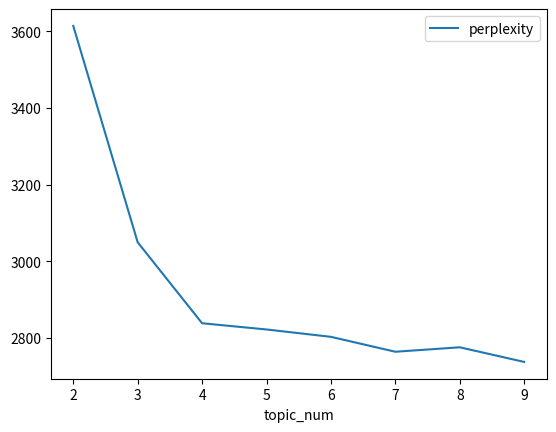

In [33]:
result.plot.line(x='topic_num', y='perplexity')

<AxesSubplot:xlabel='topic_num'>

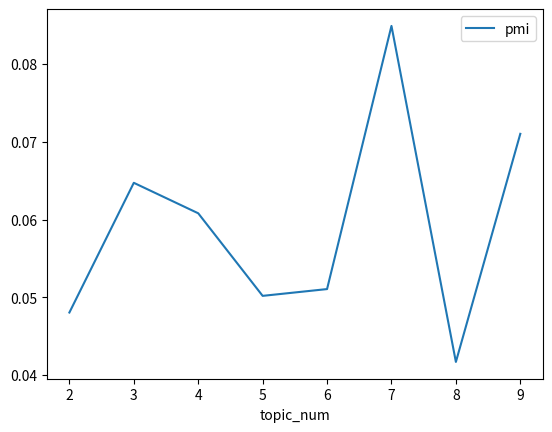

In [34]:
result.plot.line(x='topic_num', y='pmi')

就訓練結果來看，最佳的主題數落在 4，接近原始3個類別的新聞數量

## 5. 視覺化呈現

**5.1 產生 LDAvis 結果**

LDAvis 是我們經常會使用的視覺化工具，目的為幫助我們解釋主題模型中，在我們建構好主題模型得到 θ(文件的主題分佈) 跟 φ(主題的字分佈)，透過 pyLDAvis 將主題降維成二維，以網頁的形式供我們查看。

+ 四個主題數，因此有四個圈圈
+ 圓越大代表 document 越大
+ 右邊可以看到主題的字分佈
+ 右上幫有一個 bar 調整 lambda：當 lambda=1 也就是代表本來的字分佈 φ，將 lambda 縮越小可以看到越唯一的字，好的分佈是 φ 高且唯一，因此我們要在這兩者間取平衡
+ 圓心越相近，代表主題會越相似；反之，圓心分越開代表主題有唯一性<br>
  --> 假設詞彙本來有 100 字，維度應該是 100，假如本來維度接近(相近)的話，降維後也會接近(相近)

以下用主題數 7 來做 LDAvis 的結果範例

In [36]:
model = LdaModel(
    corpus = corpus,
    num_topics = 7,
    id2word=dictionary,
    random_state = 1500,
    passes = 5 # 訓練次數
    )

2023-04-30 22:26:08,815 : INFO : using symmetric alpha at 0.14285714285714285
2023-04-30 22:26:08,818 : INFO : using symmetric eta at 0.14285714285714285
2023-04-30 22:26:08,823 : INFO : using serial LDA version on this node
2023-04-30 22:26:08,845 : INFO : running online (multi-pass) LDA training, 7 topics, 5 passes over the supplied corpus of 5985 documents, updating model once every 2000 documents, evaluating perplexity every 5985 documents, iterating 50x with a convergence threshold of 0.001000
2023-04-30 22:26:08,849 : INFO : PROGRESS: pass 0, at document #2000/5985
2023-04-30 22:26:11,323 : INFO : merging changes from 2000 documents into a model of 5985 documents
2023-04-30 22:26:11,332 : INFO : topic #5 (0.143): 0.021*"經典賽" + 0.014*"今天" + 0.009*"棒球" + 0.008*"比賽" + 0.007*"世界" + 0.006*"中華隊" + 0.006*"日本" + 0.006*"台灣" + 0.006*"預賽" + 0.005*"球迷"
2023-04-30 22:26:11,333 : INFO : topic #4 (0.143): 0.020*"經典賽" + 0.015*"今天" + 0.009*"中華隊" + 0.008*"台灣" + 0.008*"棒球" + 0.007*"世界" + 0.006*"賽事"

In [37]:
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(model, corpus, dictionary)
p

/home/evan19983314/.conda/envs/py37/lib/python3.7/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.219523 -0.146707       1        1  27.345102
0     -0.221404  0.039623       2        1  25.628383
4      0.063603  0.192276       3        1  14.083388
1     -0.052615  0.218905       4        1  11.253193
2      0.144023 -0.068495       5        1   9.174625
3     -0.267419 -0.201877       6        1   7.861079
6      0.114288 -0.033725       7        1   4.654229, topic_info=     Term         Freq        Total Category  logprob  loglift
4120   億元  4516.000000  4516.000000  Default  30.0000  30.0000
41    經典賽  8935.000000  8935.000000  Default  29.0000  29.0000
9820   營收  3413.000000  3413.000000  Default  28.0000  28.0000
148    中國  7615.000000  7615.000000  Default  27.0000  27.0000
68     去年  5342.000000  5342.000000  Default  26.0000  26.0000
...   ...          ...          ...      ...      ...      ...
1033   表現   204.291724  3020.699908   Topic7  -5.6516   0.3737
3407   戰績   187.617053  1983.728135   Topic7  -5.7367   0.7091
123    表示   216.725802  6325.203964   Topic7  -5.5925  -0.3063
31     比賽   183.415481  3498.612556   Topic7  -5.7594   0.1190
38     目前   175.020558  2403.586904   Topic7  -5.8062   0.4476

[601 rows x 6 columns], token_table=       Topic      Freq  Term
term                        
4422       2  0.011633  一次會議
4422       3  0.948121  一次會議
4422       4  0.029083  一次會議
4422       5  0.005817  一次會議
7875       3  0.987244    一言
...      ...       ...   ...
11977      5  0.975858    高商
8473       1  0.151700    魔術
8473       7  0.843833    魔術
13878      2  0.991918    點收
9765       7  0.949928   齊澤姆

[1743 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 1, 5, 2, 3, 4, 7])

lambda 的意義: <https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf>

In [38]:
pyLDAvis.save_html(p, "lda_zh.html")

## 6. 主題分佈的應用，搭配其他文章資訊

In [39]:
# 取得每條新聞的主題分佈
topics_doc = model.get_document_topics(corpus)

In [40]:
topics_doc[100]

[(5, 0.9882046)]

In [41]:
m_theta = corpus2csc(topics_doc).T.toarray()
m_theta

array([[0.02502264, 0.        , 0.        , ..., 0.        , 0.49660641,
        0.47206932],
       [0.        , 0.        , 0.        , ..., 0.        , 0.9941467 ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.98897183,
        0.        ],
       ...,
       [0.02813292, 0.1603559 , 0.        , ..., 0.77233016, 0.        ,
        0.03662696],
       [0.        , 0.        , 0.        , ..., 0.99338287, 0.        ,
        0.        ],
       [0.        , 0.02845696, 0.        , ..., 0.96644789, 0.        ,
        0.        ]])

In [42]:
udn['topic_label'] = m_theta.argmax(axis=1) + 1

In [43]:
udn['topic_label'].value_counts()

1    1835
6    1324
5     885
4     662
2     607
3     426
7     246
Name: topic_label, dtype: int64

In [44]:
udn.head()

,content,artUrl,artCatagory,artDate,words,topic_label
0,世界棒球經典賽將在月日開打大聯盟也在拍賣網站推出歷屆經典賽實戰用品供球迷競標目前所有拍賣物品...,https://udn.com/news/story/10785/7001130,運動,2023-03-01 11:46:00,"[世界, 棒球, 經典賽, 將在, 開打, 大聯盟, 拍賣, 網站, 推出, 歷屆, 經典賽...",6
1,世界棒球經典賽將在月日開打中華隊首戰對手巴拿馬隊今天公布最終人名單其中有名現役大聯盟球員還有...,https://udn.com/news/story/10785/7001237,運動,2023-03-01 12:09:00,"[世界, 棒球, 經典賽, 將在, 開打, 中華隊, 首戰, 對手, 巴拿馬, 今天, 公布...",6
2,世界棒球經典賽將在下周月日開打將代表日本出征的大谷翔平今天進行春訓初登板賽後馬上啟程返日準備...,https://udn.com/news/story/10785/7002171,運動,2023-03-01 17:21:00,"[世界, 棒球, 經典賽, 將在, 下周, 開打, 代表, 日本, 出征, 大谷翔平, 今天...",6
3,旅美投手鄧愷威加入中華隊的時間出爐總教練林岳平今天表示為了配合大聯盟的規範鄧愷威今天搭機返台...,https://udn.com/news/story/10785/7002266,運動,2023-03-01 17:40:00,"[旅美, 投手, 鄧愷威, 加入, 中華隊, 時間, 出爐, 總教練, 林岳平, 今天, 表...",6
4,古巴隊昨天以擊敗味全龍拿下來台後熱身賽首勝這三場比賽中華隊教練團都有觀察總教練大餅林岳平更指...,https://udn.com/news/story/10785/7002313,運動,2023-03-01 17:56:00,"[古巴隊, 昨天, 擊敗, 味全龍, 拿下來台, 熱身賽, 首勝, 這三場, 比賽, 中華隊...",6


In [45]:
udn['artDate'] = pd.to_datetime(udn['artDate'])


In [46]:
udn['artDate'].dt.date

0       2023-03-01
1       2023-03-01
2       2023-03-01
3       2023-03-01
4       2023-03-01
           ...    
5980    2023-03-30
5981    2023-03-30
5982    2023-03-30
5983    2023-03-30
5984    2023-03-31
Name: artDate, Length: 5985, dtype: object

In [47]:
udn.groupby(udn['artDate'].dt.date)['topic_label'].value_counts(normalize=True)

artDate     topic_label
2023-03-01  1              0.275641
            6              0.211538
            5              0.179487
            2              0.115385
            7              0.108974
                             ...   
2023-03-31  6              0.150235
            2              0.136150
            3              0.065728
            7              0.065728
            4              0.051643
Name: topic_label, Length: 209, dtype: float64

In [48]:
date_topic = udn.groupby(udn['artDate'].dt.date)['topic_label'].value_counts(normalize=True).unstack()
date_topic.head()

topic_label,1,2,3,4,5,6,7
artDate,,,,,,,
2023-03-01,0.275641,0.115385,0.032051,0.076923,0.179487,0.211538,0.108974
2023-03-02,0.274854,0.157895,0.093567,0.052632,0.187135,0.157895,0.076023
2023-03-03,0.229814,0.086957,0.049689,0.049689,0.198758,0.236025,0.149068
2023-03-04,0.126126,0.081081,0.126126,0.009009,0.225225,0.342342,0.090090
2023-03-05,0.282609,0.115942,0.072464,0.021739,0.130435,0.282609,0.094203


<AxesSubplot:xlabel='artDate'>

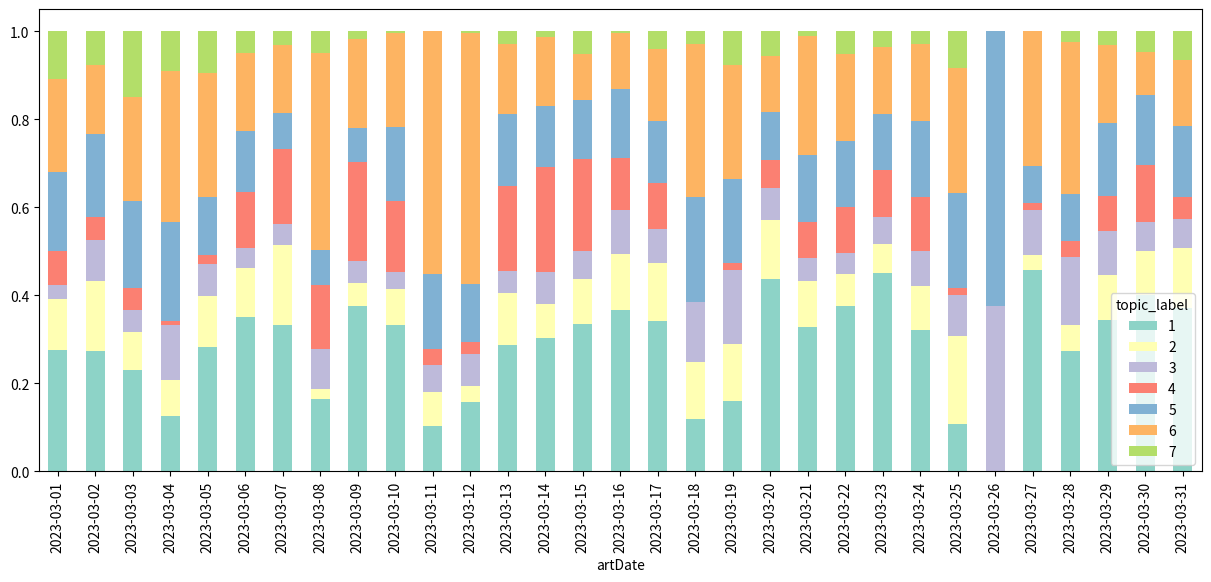

In [49]:
fig, ax = plt.subplots(figsize=(15, 6))
date_topic.plot.bar(ax=ax, stacked=True, color = plt.cm.Set3.colors)

透過搭配文章的資訊（例如日期等），可以讓主題模型的結果做出更多的分析應用